<h1 align="center">Smart Home Sensor Analysis</h1>
<p>The ‘Household Power Consumption‘ dataset is a multivariate time series dataset that describes the electricity consumption for a single household for last few months. The  dataset is modeled after household consumption dataset available here - 
https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption


It is a multivariate series comprised of seven variables (besides the date and time); they are:

<b>global_active_power:</b> The total active power consumed by the household (kilowatts).<br>
<b>global_reactive_power:</b> The total reactive power consumed by the household (kilowatts).<br>
<b>voltage:</b> Average voltage (volts).<br>
<b>global_intensity:</b> Average current intensity (amps).<br>
<b>sub_metering_1:</b> Active energy for kitchen (watt-hours of active energy).<br>
<b>sub_metering_2:</b> Active energy for laundry (watt-hours of active energy).<br>
<b>sub_metering_3:</b> Active energy for climate control systems (watt-hours of active energy).<br>

<p> In the following section, we will analyze and predict hourly power consumption using DeepAR on SageMaker. The purpose of this exercise is to demonstrate Sagemaker integration with IoT Analytics and not to focus on training the right model to generate accurate prediction.
<p>For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110), 

In [1]:
from __future__ import print_function
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from sagemaker import get_execution_role


In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [4]:
s3_bucket = sagemaker.Session().default_bucket()# replace with an existing bucket if needed

s3_prefix = 'iot-analytics-demo-notebook'    # prefix used for all data stored within the bucket

role = get_execution_role()


In [5]:
region = sagemaker_session.boto_region_name
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [24]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", region, "latest")
print(image_uri)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


### Import  dataset from the IotAnalytics database and upload it to S3 to make it available for Sagemaker

In [7]:
## reading from the IotAnalytics database
import pandas as pd
from datetime import datetime
from numpy import isnan
import pandas as pd
from datetime import datetime
from numpy import isnan


bucket='iotareinvent18'
data_key = 'inputdata.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)


# Function to convert date columns into a single timestamp field
#def parse(x):
#    return datetime.strptime(x, '%Y %m %d %H')
def parse(x):
    t= pd.to_datetime(str(x)) 
    timestring = t.strftime('%Y.%m.%d %H:%M:%S')
    return t

def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
 
# load sample data

#n = sum(1 for line in open(data_location)) - 1 #number of records in file (excludes header)
n=244207 #total observations
s = 10000 #desired sample size
sampling = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list

dataset = pd.read_csv(data_location,  header=0, skiprows=sampling ,low_memory=False, infer_datetime_format=True, date_parser = parse)
dataset['__dt'] = dataset['timestamp']
dataset['cost'] = (dataset['sub_metering_1'] +dataset['sub_metering_2'] + dataset['sub_metering_3'])*1.5
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.set_index('timestamp', inplace=True)


In [8]:
print("#####Examine the dataset")
print("dataset shape ",dataset.shape)
print(dataset.sample(5))


#####Examine the dataset
dataset shape  (10000, 9)
                     global_active_power  global_reactive_power  voltage  \
timestamp                                                                  
2018-09-21 11:28:00                 2.05                   0.75   237.85   
2018-08-26 00:40:00                 0.29                   0.09   242.73   
2018-06-30 05:14:00                 1.54                   0.32   238.85   
2018-08-26 20:16:00                 0.38                   0.09   243.18   
2018-08-23 07:05:00                 0.43                   0.09   242.36   

                     global_intensity  sub_metering_1  sub_metering_2  \
timestamp                                                               
2018-09-21 11:28:00               9.8               0               0   
2018-08-26 00:40:00               1.4               0               0   
2018-06-30 05:14:00               6.6               0               1   
2018-08-26 20:16:00               1.6              

<h3>Explore the data</h3>


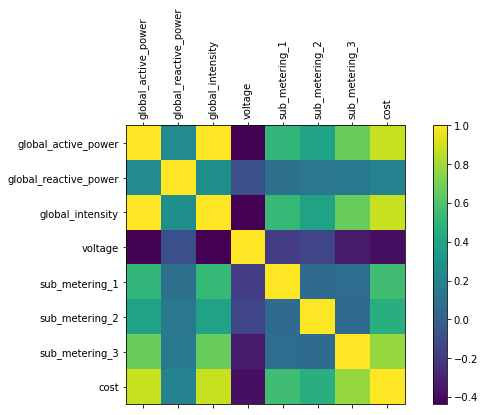

In [10]:

cor_cols = ["global_active_power","global_reactive_power", "global_intensity","voltage","sub_metering_1","sub_metering_2","sub_metering_3","cost"]


# plot correlation matrix
plt.figure(figsize=(10,5))

plt.matshow(dataset.loc[:, cor_cols].corr(), fignum=1)
plt.xticks(range(len(cor_cols)), cor_cols, rotation=90)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

<p><b>Correlation Plot</b>
<p>The correlation plot, we can observe that Sub Meters 1 and 2 show some correlation with each other. Sub meter 3 has less correlation with Sub meter 1 and 2. Since cost is derived by aggregating Sub Meter 1, 2 and 3, we will retain only cost column to train the model.

In [11]:
##updating data to dataset
analysis_cols = ["global_active_power","global_reactive_power", "global_intensity","voltage","cost"]

# select the value columns in the DataFrame to compare
dataset= dataset.loc[:, analysis_cols]


Then, we load and parse the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier. Here we want to forecast longer periods (one week) and resample the data to a granularity of every hour.

In [12]:
num_timeseries = dataset.shape[1]
data_kw = dataset.resample('2H').sum()
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [13]:
# we use 1 (changed 2 to 1) hour frequency for the time series
freq = '2H' 

# we predict for 7 days
prediction_length = 7 * 12  ##original 7*12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12 ##original 7*12 due to 2H sample

Here, we assume that the minimum date is the first day sensors started recording the dataset. We split the dataset 70, 30 with 70% of the data retained for training.

In [14]:
dailyGroups = dataset.resample('D').sum() ## Gathering unique days for dataset split
dailyGroups

,global_active_power,global_reactive_power,global_intensity,voltage,cost
timestamp,,,,,
2018-05-30,8.26,0.83,34.8,1446.99,103.5
2018-05-31,42.40,4.73,179.8,11091.73,607.5
2018-06-01,63.75,4.59,269.8,17089.58,975.0
2018-06-02,35.31,4.13,150.8,12753.60,513.0
2018-06-03,64.33,8.01,277.8,15117.75,1069.5
...,...,...,...,...,...
2018-11-21,32.85,4.52,138.4,13795.45,262.5
2018-11-22,79.28,4.30,336.0,13942.78,1036.5
2018-11-23,61.35,5.11,263.6,14487.99,619.5


In [15]:

startTrainDate = dailyGroups.index.min()

maxDate=dailyGroups.index.max()


traingSplit=round(dailyGroups.shape[0]*.7)


splitDate=dailyGroups.index[traingSplit]


start_dataset = pd.Timestamp(startTrainDate, freq=freq)
end_training = pd.Timestamp(splitDate, freq=freq)

print("###### Confirm the datasets")
print("startTrainDate, maxDate, traingSplit, splitDate", startTrainDate, maxDate, traingSplit, splitDate)


###### Confirm the datasets
startTrainDate, maxDate, traingSplit, splitDate 2018-05-30 00:00:00 2018-11-25 00:00:00 126 2018-10-03 00:00:00


The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [16]:


training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - pd.Timedelta(1, unit='D')].tolist()
         # We use -1 days, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2, 3, 4 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [17]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + pd.Timedelta(k, unit='D') * prediction_length].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [18]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [19]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 24.8 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [20]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=True):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [21]:
%%time
copy_to_s3("train.json", s3_output_path + "/train/train.json")
copy_to_s3("test.json", s3_output_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-710299592439/iot-analytics-demo-notebook/output/train/train.json
Uploading file to s3://sagemaker-us-east-1-710299592439/iot-analytics-demo-notebook/output/test/test.json
CPU times: user 36.5 ms, sys: 9.37 ms, total: 45.9 ms
Wall time: 267 ms


Let's have a look to what we just wrote to S3.

In [22]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_output_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2018-05-30 00:00:00", "target": [7.15, 1.1099999999999999, 1.32, 0.42000000000000004, 0.9...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [25]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-electricity-demo',
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [26]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "40",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "1E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [27]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [28]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_output_path),
    "test": "{}/test/".format(s3_output_path)
}

estimator.fit(inputs=data_channels, wait=True)

2021-03-21 13:40:51 Starting - Starting the training job...
2021-03-21 13:41:14 Starting - Launching requested ML instancesProfilerReport-1616334050: InProgress
......
2021-03-21 13:42:15 Starting - Preparing the instances for training...
2021-03-21 13:42:50 Downloading - Downloading input data...
2021-03-21 13:43:15 Training - Downloading the training image...
2021-03-21 13:43:42 Training - Training image download completed. Training in progress..Arguments: train
[03/21/2021 13:43:45 INFO 140029106595200] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers'

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [39]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type="application/json", **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + pd.Timedelta(1, unit='D')

        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        #prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [44]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m4.xlarge',
#     predictor_cls=DeepARPredictor)

-----------------!

In [52]:
from sagemaker.predictor import json_serializer
from sagemaker.predictor import json_deserializer
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session, serializer=json_serializer, deserializer=json_deserializer)
#predictor.set_prediction_parameters(freq, prediction_length)

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Make predictions 

Now we can use the `predictor` object to generate predictions.

In [53]:
respDF=predictor.predict(ts=timeseries[4], quantiles=[0.90])

The json_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


TypeError: Object of type 'bytes' is not JSON serializable

Printing predicted cost for next 10 hours  at 0.9 quantile. Please note, the data is generated using Device simulators and not recorded by actual sensors. Predicted cost can sometime display negative numbers, which will not be the case in case of real life scenario. Power company will never credit money for low consumption!!!!! 

In [37]:
respDF.head(10)

NameError: name 'respDF' is not defined

### Delete endpoints

In [43]:
predictor.delete_endpoint()